In [59]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import *
from plot_main_encoder import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

# sns.set_theme('notebook', 'darkgrid')
# palette = sns.color_palette('colorblind')

run_dir = "../encoder_final"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load all runs and gather metrics

In [60]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
5,61d98bbc-7d30-4cce-b23f-dc66fe858c2a,linear_and_logistic_d=20,EncoderTF,-1,-1,20,12,8,linear_and_logistic_d=20
6,15c1815e-0fba-4230-9441-4782573ede61,linear_classification,EncoderTF,-1,-1,20,12,8,linear_classification
3,e32cc54c-d7cf-4878-b9a7-c49ea5dbe918,linear_regression,EncoderTF,-1,-1,20,12,8,linear_regression
1,c8244fed-c938-455d-a673-c268f7e31d3e,nlr_d=20_normalize_mtl,EncoderTF,-1,-1,20,12,8,nlr_d=20_normalize_mtl
4,91c405c4-cf66-4883-8516-00a480df16fb,nlr_d=20_normalize_noise=0.1,EncoderTF,-1,-1,20,12,8,nlr_d=20_normalize_noise=0.1
2,50bcac52-4593-4dea-8a24-d447dd77ef86,nlr_d=20_normalize_noise=0.25,EncoderTF,-1,-1,20,12,8,nlr_d=20_normalize_noise=0.25
12,fda80159-7318-4ea1-9c08-4acd2786b82b,nlr_d=20_normalize_noise=0.5,EncoderTF,-1,-1,20,12,8,nlr_d=20_normalize_noise=0.5
14,df4e4eeb-d05d-4727-8147-2f757b8c279f,nlr_d=20_normalize_noise=1.0,EncoderTF,-1,-1,20,12,8,nlr_d=20_normalize_noise=1.0
8,a9c83386-66a0-4c82-9675-31f59a0a8fd7,slr_d=20_k=3_normalize_fixedcurr,EncoderTF,-1,-1,20,12,8,slr_d=20_k=3_normalize_fixedcurr
17,58b1c4c0-9eca-43f1-8ac2-8ee2ad81c16c,slr_d=20_k=3_normalize_guided_lam_0.01_token_10_layer_-2,EncoderTF,-1,-1,20,12,8,slr_d=20_k=3_normalize_guided_lam_0.01_token_10_layer_-2


In [38]:
%%capture
metrics = collect_all_results(run_dir, df)

In [26]:
# Evaluate linear and logistic model

run_name = "linear_and_logistic_d=20"
run_id = "61d98bbc-7d30-4cce-b23f-dc66fe858c2a"

run_path = os.path.join(run_dir, run_name, run_id)
recompute_metrics = True

############ Set number of evaluation examples #############
num_eval_examples = 6400
############################################################

if recompute_metrics:
    all_task_names = ["linear_regression", "linear_classification"]
    get_run_metrics(
        run_path, all_task_names=all_task_names, recompute=True, 
        num_eval_examples=num_eval_examples,
        # step=100000, 
    )  # these are normally precomputed at the end of training

{'linear_regression': {'n_dims': 20, 'n_points': 41, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard', 'num_eval_examples': 6400, 'task_name': 'linear_regression', 'task_sampler_kwargs': {'normalize_w': True}}, 'linear_classification': {'n_dims': 20, 'n_points': 41, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard', 'num_eval_examples': 6400, 'task_name': 'linear_classification'}}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:52<00:00, 26.19s/it]


## (Optionally) Re-compute evals of trained models

In [114]:
# Evaluate linear model

run_name = "linear_regression"
run_id = "062875cd-dff6-4dba-bc88-a70b3a1e00a3"

run_path = os.path.join(run_dir, run_name, run_id)
recompute_metrics = True

############ Set number of evaluation examples #############
num_eval_examples = 6400
############################################################

if recompute_metrics:
    all_task_names = ["linear_regression", "linear_classification"]
    get_run_metrics(
        run_path, all_task_names=all_task_names, recompute=True, 
        num_eval_examples=num_eval_examples,
        # step=100000, 
    )  # these are normally precomputed at the end of training

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:34<00:00, 17.00s/it]


In [49]:
# Evaluate ridge mtl model
run_name = "nlr_d=20_normalize_mtl"
run_id = "c8244fed-c938-455d-a673-c268f7e31d3e"

run_path = os.path.join(run_dir, run_name, run_id)
recompute_metrics = True

lams = [0.2, 5]
if recompute_metrics:
    all_task_names = ["noisy_linear_regression"]
    get_run_metrics(
        run_path, all_task_names=all_task_names, recompute=True, 
        num_eval_examples=num_eval_examples,
    )  # these are normally precomputed at the end of training

{'noisy_linear_regression_noise=1.0': {'n_dims': 20, 'n_points': 21, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard', 'num_eval_examples': 6400, 'task_name': 'noisy_linear_regression', 'task_sampler_kwargs': {'normalize_w': True, 'noise_std': 1.0}}, 'noisy_linear_regression_noise=0.5': {'n_dims': 20, 'n_points': 21, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard', 'num_eval_examples': 6400, 'task_name': 'noisy_linear_regression', 'task_sampler_kwargs': {'normalize_w': True, 'noise_std': 0.5}}, 'noisy_linear_regression_noise=0.25': {'n_dims': 20, 'n_points': 21, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard', 'num_eval_examples': 6400, 'task_name': 'noisy_linear_regression', 'task_sampler_kwargs': {'normalize_w': True, 'noise_std': 0.25}}, 'noisy_linear_regression_noise=0.1': {'n_dims': 20, 'n_points': 21, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard', 'num_eval_examples': 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [18:21<00:00, 275.38s/it]


In [84]:
%%capture
# Read newest results
metrics = collect_all_results(run_dir, df)

# Make ridge MTL plot

In [23]:
errs_1, errs_2 = get_ridge_errors(d=20, N=20)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


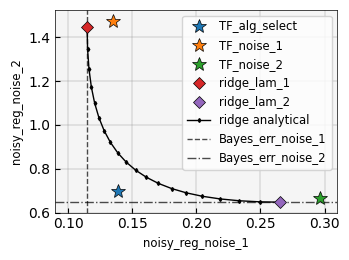

In [197]:
make_ridge_mtl_plot_encoder(metrics, errs_1=errs_1, errs_2=errs_2)

# Make linear + logistic plot

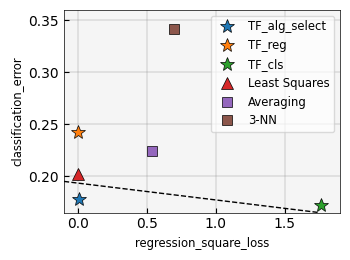

In [198]:
make_linear_logistic_plot_encoder(metrics)

# Make lasso plot

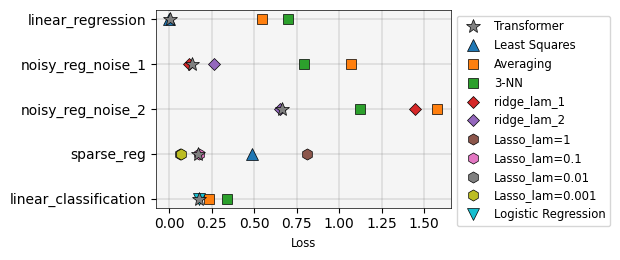

In [215]:
problems = [
    "linear_regression",
    "noisy_linear_regression_noise=0.1",
    "noisy_linear_regression_noise=0.5",
    "sparse_linear_regression",
    "linear_classification",
]
run_names = [
    "linear_regression",
    "nlr_d=20_normalize_noise=0.1",
    "nlr_d=20_normalize_noise=0.5",
    "slr_d=20_k=3_normalize_guided_lam_0.1_token_5_layer_-2",
    "linear_classification",
]
problem_labels = [
    "linear_regression",
    "noisy_reg_noise_1",
    "noisy_reg_noise_2",
    "sparse_reg",
    "linear_classification",
]
inds = [40, 20, 20, 10, 40]
plot_bar(metrics, problems, run_names, problem_labels=problem_labels, 
         inds=inds, flip_problems=["linear_classification"], error_bar=False,
         figsize=(6.3, 2.7), alpha=1.0)